# Demo1 - データが少ない場合の学習

In [10]:
import numpy as np
import tensorflow as tf
import tfgraphviz as tfg
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
%matplotlib inline

## 1. データの準備

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Data Info
         value
-----  -------
train     1100
test       200


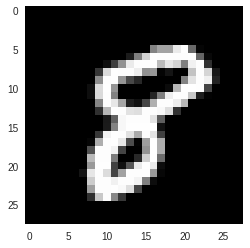

In [6]:
# データの準備
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# データを少なくする
train_images, _, train_labels, _ = train_test_split(mnist.train.images,
                                    mnist.train.labels, test_size=0.98)
test_images, _, test_labels, _ = train_test_split(mnist.test.images,
                                               mnist.test.labels, test_size=0.98)

mnist.train._images = train_images
mnist.train._labels = train_labels
mnist.train._num_examples = train_images.shape[0]
mnist.test._images = test_images
mnist.test._labels = test_labels
mnist.test._num_examples = test_images.shape[0]


# データの情報表示
data_info = [
    ['train', mnist.train.images.shape[0]],
    ['test', mnist.test.images.shape[0]]
]

print('\nData Info')
print(tabulate.tabulate(data_info, ['value']))

# 1枚画像を表示する
sns.set_style('dark')
plt.imshow(mnist.train.images[0].reshape([28, 28]))
plt.gray()

## 2. モデルの構築

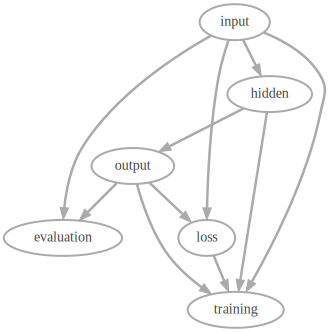

In [7]:
# ネットワークの構築
tf.reset_default_graph()
g = tf.get_default_graph()

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 28*28])
    y_ = tf.placeholder(tf.float32, [None, 10])

with tf.name_scope('hidden'):
    W1 = tf.Variable(tf.truncated_normal(shape=[28*28, 144], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[144]))
    hidden = tf.nn.relu(tf.matmul(x, W1) + b1)

with tf.name_scope('output'):
    W2 = tf.Variable(tf.truncated_normal(shape=[144, 10], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[10]))
    output = tf.nn.softmax(tf.matmul(hidden, W2) + b2)

with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_))

with tf.name_scope('training'):
    train_op = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
tfg.board(g, depth=1, style=True)

## 3. 学習 + 評価

In [24]:
# tensorflowのセッションの開始
sess = tf.InteractiveSession()

# 設定したtensorflowの変数や定数を初期化
sess.run(tf.global_variables_initializer())

# プログレスバーの設定
#pb = TfProgBar(target=mnist.train.images.shape[0],
#               batch_size=50,
#               epochs=20)

train_accs   = []
train_losses = []
test_accs    = []
test_losses  = []

temp_train_accs = []
temp_train_losses = []
# 学習の開始
for step in tqdm_notebook(range(1, 10000 + 1)):
    # 50個ずつ画像とラベルをトレーニングデータセットから抽出する
    batch_x, batch_y = mnist.train.next_batch(50)
    feed_dict = {x: batch_x, y_:batch_y}
    
    # 上記で抽出したトレーニングデータ・セットで学習させる
    sess.run(train_op, feed_dict=feed_dict)
    
    # 損失と正解率を測定
    train_acc, train_loss = sess.run([accuracy, loss], feed_dict=feed_dict)
    temp_train_accs.append(train_acc)
    temp_train_losses.append(train_loss)
    
    # 200 ステップに1回テストデータ・セットに対する損失と正解率を測定する
    if step % 20 == 0:
        test_x, test_y = mnist.test.images, mnist.test.labels
        test_acc, test_loss = sess.run([accuracy, loss], feed_dict={x:test_x, y_:test_y})
        
        mean_train_accs = np.mean(temp_train_accs)
        mean_train_losses = np.mean(temp_train_losses)
        train_accs.append(mean_train_accs)
        train_losses.append(mean_train_losses)
        test_accs.append(test_acc)
        test_losses.append(test_loss)
        temp_train_accs = []
        temp_train_losses = []

print("test accuracy: %.5f" % test_acc)
print("test loss: %.5g" % test_loss)


test accuracy: 0.90500
test loss: 1.5617


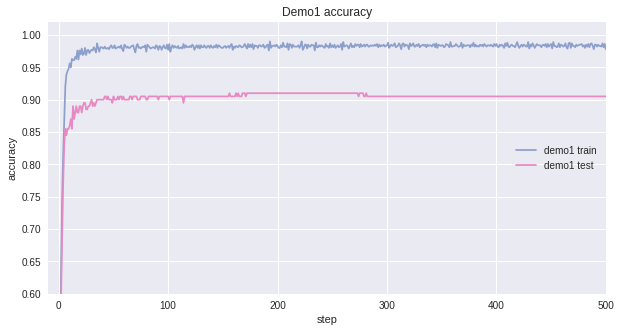

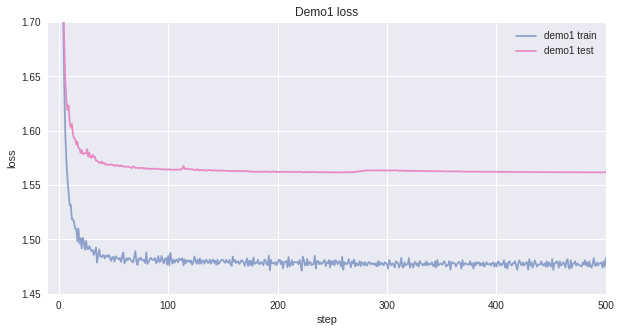

In [31]:
# グラフの表示
## 正解率
colors = sns.color_palette("Set2", 10)
sns.set_style('darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
xvalues = np.arange(1, len(train_accs) + 1)
ax.plot(xvalues, train_accs, label='demo1 train', color=colors[2])
ax.plot(xvalues, test_accs, label='demo1 test', color=colors[3])
ax.set_ylim(0.6, 1.02)
ax.set_xlim(-10, 500)
ax.set_xlabel("step")
ax.set_ylabel("accuracy")
plt.legend(loc='center right')
ax.set_title('Demo1 accuracy')

## 損失
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
xvalues = np.arange(1, len(train_losses) + 1)
ax.plot(xvalues, train_losses, label='demo1 train', color=colors[2])
ax.plot(xvalues, test_losses, label='demo1 test', color=colors[3])
ax.set_xlim(-10, 500)
ax.set_ylim(1.45, 1.7)
ax.set_xlabel("step")
ax.set_ylabel("loss")
plt.legend(loc='upper right')
ax.set_title('Demo1 loss')

## 推論

予測: 6


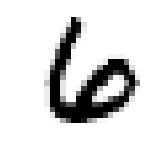

In [27]:
# 推論する
test_image_index = 3
test_image_no = mnist.test.labels[test_image_index].argmax()

test_image_data = mnist.test.images[test_image_index]
result = sess.run(output, feed_dict={x: [test_image_data]})

sns.set_style('dark')
fig = plt.figure(figsize=(8, 6))

## テスト対象の画像
ax = fig.add_subplot(2, 1, 1)
ax.tick_params(labelbottom='off')
ax.tick_params(labelleft='off')
ax.imshow(test_image_data.reshape([28, 28]))

print("予測: %d" % result.argmax())

In [28]:
# 結果データをnp形式で保存
np.savez('demo1_result.npz', train_accs=train_accs, train_losses=train_losses, test_accs=test_accs, test_losses=test_losses)